Define

In [14]:
import sys
import torch.utils.data as tordata
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import torch

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib as mpl
import SimpleITK as sitk


from datetime import datetime
from warnings import warn
from typing import Optional
# import torchvision.models as models
# %matplotlib inline
from collections import OrderedDict
import os
# from torchsummary import summary

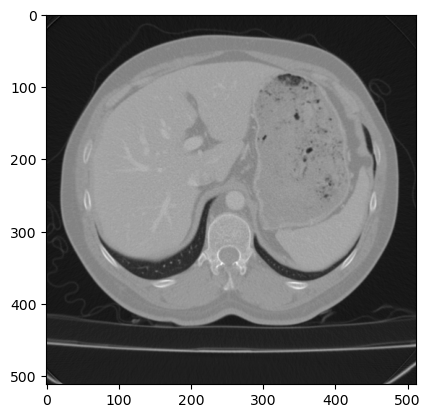

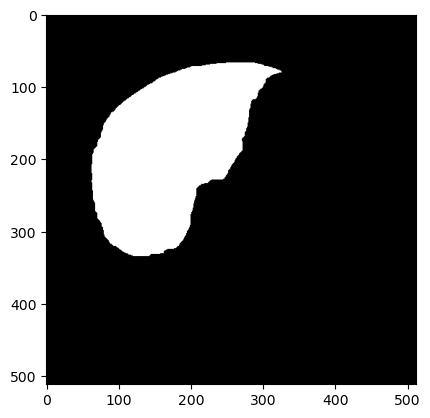

In [15]:
dicom_directory = '/bulk/liangy15/CHAOS/Train_Sets/CT/1/DICOM_anon/i0040,0000b.dcm'
ground_dir = '/bulk/liangy15/CHAOS/Train_Sets/CT/1/Ground/liver_GT_040.png'
# Read the DICOM file using pydicom
ds = sitk.ReadImage(dicom_directory)
image_np = sitk.GetArrayFromImage(ds)
ground = plt.imread(ground_dir)
plt.imshow(image_np[0], cmap='gray')
plt.show()
plt.imshow(ground, cmap='gray')
# ds = pydicom.dcmread(dicom_directory)
# image_np = ds.pixel_array



In [26]:
DATASET_PATH = '/bulk/liangy15/CHAOS/'
Train_Path = '/bulk/liangy15/CHAOS/Train_Sets/CT/'
Train_Set = [1,2,5,6,8,10,14,16,18,19,21,22,23,24,25,26,27,28,29,30]
Val_Set = [26,27,28,29,30]
Test_Set = [3,4,7,9,11,12,13,15,17,20,31,32,33,34,35,36,37,38,39,40]
Test_Path = '/bulk/liangy15/CHAOS/Test_Sets/CT/'

DataSet

In [27]:
class DataSet(tordata.Dataset):
    def __init__(self, path, set,  mode = []):
        super(DataSet, self).__init__()
        self.img_path_list = []
        self.ground_path_list = []
        self.path = path 
        self.mode = mode
        self.set = set
        self.data_path = []
        self.folder = []
        if mode == 'train':
            for i in range(len(set)):
                data_path = os.path.join(path, str(set[i]), 'DICOM_anon')
                data_path_img = os.listdir(data_path)
                try: data_path_img.sort(key=lambda x:int(x[1:5]))
                except: data_path_img.sort(key=lambda x:int(x[9:14]))
                ground_path = os.path.join(path, str(set[i]), 'Ground')
                data_path_ground = os.listdir(ground_path)
                data_path_ground.sort(key=lambda x:int(x[9:12]))
                for k in range(len(data_path_img)):
                    img_name = data_path_img[k]
                    ground_name = data_path_ground[k]
                    img_path = os.path.join(self.path, str(set[i]),'DICOM_anon', img_name)
                    ground_path = os.path.join(self.path, str(set[i]),'Ground', ground_name)
                    mask = plt.imread(ground_path)
                    if np.count_nonzero(mask) != 0:
                        self.img_path_list.append(img_path)
                        self.ground_path_list.append(ground_path)
        elif mode == 'test':
            for i in range(len(set)):
                data_path = os.path.join(path, str(set[i]), 'DICOM_anon')
                data_path_img = os.listdir(data_path)
                try: data_path_img.sort(key=lambda x:int(x[1:5]))
                except: data_path_img.sort(key=lambda x:int(x[9:14]))
                for k in range(len(data_path_img)):
                    img_name = data_path_img[k]
                    img_path = os.path.join(self.path, str(set[i]),'DICOM_anon', img_name)
                    self.img_path_list.append(img_path)
                    self.folder.append(set[i])
    def __getitem__(self, index):
        if self.mode == 'train':
            img_item_path = self.img_path_list[index]
            ground_item_path = self.ground_path_list[index]
            ds = sitk.ReadImage(img_item_path)
            data = sitk.GetArrayFromImage(ds)
            data = torch.tensor(data).float()
            data = torch.clamp(data, -160., 240.) 
            data = (data - torch.min(data))/(torch.max(data) - torch.min(data))
            mask = plt.imread(ground_item_path)
            mask = torch.tensor(mask).float()
            return data, mask
        elif self.mode == 'test':
            img_item_path = self.img_path_list[index]
            ds = sitk.ReadImage(img_item_path)
            data = sitk.GetArrayFromImage(ds)
            data = torch.tensor(data).float()
            data = torch.clamp(data, -160., 240.) 
            data = (data - torch.min(data))/(torch.max(data) - torch.min(data))
            return data, self.folder[index]
        
    def __len__(self):
        return len(self.img_path_list)
        


In [28]:
trainsource = DataSet(Train_Path, Train_Set, mode='train')
valsource = DataSet(Train_Path, Val_Set, mode='train')
testsource = DataSet(Test_Path, Test_Set, mode = 'test')
print(len(trainsource), len(valsource), len(testsource))
# img, mask = trainsource[0]
# plt.imshow(img)
# print(img.size(), mask.size())

2341 742 3533


Net

In [6]:
class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, init_features = 32):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        #x = x.view(-1, 1)
        x = x.view(-1,1,512,512)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        output = torch.sigmoid(self.conv(dec1))
        output = output.view(output.size(0),output.size(2), output.size(3))
        return output
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )


Loss

In [7]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):
        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, predict, target):
        assert predict.size() == target.size(), "the size of predict and target must be equal."
       
        # num = predict.size(0)
        # pre = predict.view(num, -1)
        # tar = target.view(num, -1)

        tp = (predict*target).sum(self.dims)
        fp = (predict*(1-target)).sum(self.dims)
        fn = ((1-predict)*target).sum(self.dims)

        nominator = 2 * tp
        denominator = 2 * tp + fp + fn

        dc = (nominator + self.smooth) / (torch.clip(denominator + self.smooth, 1e-8))
        dc = dc.mean()
        
        return 1-dc

Model

In [8]:
class Model:
    def __init__(
        self,
        lr,
        num_workers,
        batch_size,
        restore_iter,
        total_epoch,
        save_name,
        model_name,
        train_source,
        val_source,
        test_source,
        prt_path):
        
        self.lr = lr
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.restore_iter = restore_iter
        self.total_epoch = total_epoch
        self.save_name = save_name
        self.model_name = model_name
        self.train_source = train_source
        self.val_source = val_source
        self.test_source = test_source
        self.prt_path = prt_path

        net = UNet().cuda()
        self.net = nn.DataParallel(net)
        optimizer = optim.Adam([{'params':self.net.parameters(), 'lr': self.lr}])
        self.optimizer = optimizer
        loss = SoftDiceLoss()
        self.loss = nn.DataParallel(loss)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, 40, gamma=0.5)
        
        self.dice_loss = []
        self.DICELOSS = []
    def fit(self):

        #self.load_pretrain(self.prt_path)
        
        if self.restore_iter != 0:
            self.load_model(self.restore_iter)
        self.net.train()
        train_loader = tordata.DataLoader(
                        dataset = self.train_source,
                        num_workers = self.num_workers,
                        batch_size = self.batch_size 
                        )
        
        #scaler = torch.cuda.amp.GradScaler()
        for epoch in range(self.restore_iter, self.total_epoch):
            _time1 = datetime.now()
            for i, x in enumerate(train_loader):
                imgs, masks = x
                # plt.imshow(np.array(imgs[0][0]), cmap = 'gray')
                # plt.show()
                # plt.imshow(np.array(masks[0]), cmap = 'gray')
                # plt.show()
                imgs = imgs.cuda()
                masks = masks.cuda()
                pred = self.net(imgs)
                dice_loss = self.loss(pred, masks).mean()
                self.dice_loss.append(dice_loss.cpu().data.numpy())
                self.optimizer.zero_grad()
                dice_loss.cuda().backward()
                self.optimizer.step() 
            self.scheduler.step()
                   
            print(datetime.now()-_time1)
            _time1 = datetime.now()
            self.save_model(epoch)
            print('epoch {}:'.format(epoch), end='')
            print(', dice_loss={0:.8f}'.format(np.mean(self.dice_loss)), end='')
            print(', lr=',self.optimizer.state_dict()['param_groups'][0]['lr'])
            sys.stdout.flush()
            self.DICELOSS.append(np.mean(self.dice_loss))
            self.dice_loss = []
                
            if (epoch+1)%10 == 0:
                plt.plot(self.DICELOSS)
                plt.show()
            
        
        
    def validate(self, mode, batch_size=1):
        self.net.eval()
        if mode =='train':
            self.source = self.train_source
        elif mode == 'val':
            self.source = self.val_source
        else: self.source = self.test_source
        data_loader = tordata.DataLoader(
                        dataset = self.source,
                        batch_size = batch_size,
                        sampler = tordata.sampler.SequentialSampler(self.source),
                        num_workers = self.num_workers)    
        
        pred_list = list()
        mask_list = list()
        folder_list = list()
        with torch.no_grad():
            if mode == 'train' or mode == 'val':
                for i,x in enumerate(data_loader):
                    imgs, masks = x
                    pred = self.net(imgs.cuda())
                    pred_list.append(pred.data.cpu().numpy())
                    mask_list.append(masks.data.cpu().numpy())
                mask_list = np.concatenate(mask_list, 0)
                pred_list = np.concatenate(pred_list, 0)
                return pred_list, mask_list
            else:
                for i,x in enumerate(data_loader):
                    imgs, folder = x
                    if torch.count_nonzero(imgs) == 0:
                        pred = np.zeros(imgs.shape)
                    else:
                        pred = self.net(imgs.cuda())
                    pred_list.append(pred.data.cpu().numpy())
                    folder_list.append(folder)
                pred_list = np.concatenate(pred_list, 0)
                folder_list = np.concatenate(folder_list, 0)
                return pred_list, folder_list


    
    def save_model(self, i):
        torch.save(self.net.state_dict(), os.path.join(
            'model',self.model_name,
            '{}-{:0>5}-net.ptm'.format(self.save_name, i)))    
        torch.save(self.optimizer.state_dict(), os.path.join(
            'model',self.model_name,
            '{}-{:0>5}-optimizer.ptm'.format(self.save_name, i)))
        
                
    def load_model(self, restore_iter=None):
        if restore_iter is None:
             restore_iter = self.restore_iter
        self.net.load_state_dict(torch.load(os.path.join(
            '/bulk/liangy15/CHAOS/model/',self.model_name,
            '{}-{:0>5}-net.ptm'.format(self.save_name, restore_iter))), False)
        self.optimizer.load_state_dict(torch.load(os.path.join(
            '/bulk/liangy15/CHAOS/model/',self.model_name,
            '{}-{:0>5}-optimizer.ptm'.format(self.save_name, restore_iter))))
            
    def load_pretrain(self, model_path):
        self.encoder.load_state_dict(torch.load(model_path), False)

Config

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"]=" 4,5,6,7"
_lr = 1e-3
print('Initialize lr as %f' % _lr)
model_config={
    'lr': _lr,
    'num_workers': 32,
    'batch_size': 64,
    'restore_iter': 0,
    'total_epoch': 200,
    'model_name': '/bulk/liangy15/model/Unet_CT/no_all_background',
    'prt_path': "/home/",
    'train_source': trainsource,
    'test_source': testsource,
    'val_source': valsource
}
model_config['save_name'] = '_'.join([
        '{}'.format(model_config['model_name']),
        '{}'.format(model_config['lr']),
        '{}'.format(model_config['batch_size']),
])

os.makedirs(os.path.join('model', model_config['model_name']), exist_ok=True)
        
m = Model(**model_config)

Initialize lr as 0.001000


Train

0:00:16.557973
epoch 0:, dice_loss=0.72758263, lr= 0.001
0:00:14.826268
epoch 1:, dice_loss=0.67287141, lr= 0.001
0:00:14.017887
epoch 2:, dice_loss=0.61141211, lr= 0.001
0:00:14.341813
epoch 3:, dice_loss=0.53657383, lr= 0.001
0:00:13.450324
epoch 4:, dice_loss=0.46035829, lr= 0.001
0:00:14.227171
epoch 5:, dice_loss=0.36874029, lr= 0.001
0:00:14.034617
epoch 6:, dice_loss=0.29970750, lr= 0.001
0:00:14.122533
epoch 7:, dice_loss=0.26021406, lr= 0.001
0:00:14.248541
epoch 8:, dice_loss=0.21457657, lr= 0.001
0:00:13.410962
epoch 9:, dice_loss=0.18753323, lr= 0.001


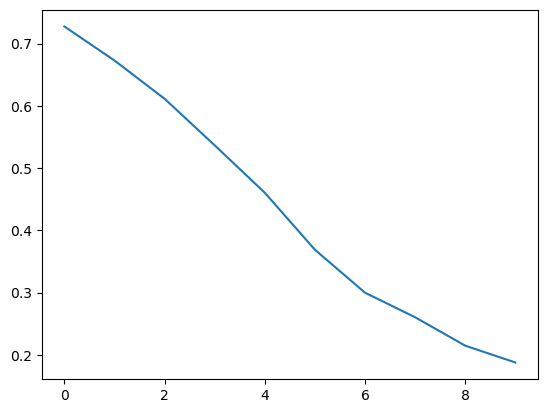

0:00:13.861728
epoch 10:, dice_loss=0.16832078, lr= 0.001
0:00:14.577576
epoch 11:, dice_loss=0.15256095, lr= 0.001
0:00:13.884447
epoch 12:, dice_loss=0.15020789, lr= 0.001
0:00:14.388646
epoch 13:, dice_loss=0.12862930, lr= 0.001
0:00:14.593742
epoch 14:, dice_loss=0.11632488, lr= 0.001
0:00:14.903877
epoch 15:, dice_loss=0.11689894, lr= 0.001
0:00:14.045224
epoch 16:, dice_loss=0.10585273, lr= 0.001
0:00:12.430647
epoch 17:, dice_loss=0.11948811, lr= 0.001
0:00:12.610668
epoch 18:, dice_loss=0.10021148, lr= 0.001
0:00:12.820005
epoch 19:, dice_loss=0.08513284, lr= 0.001


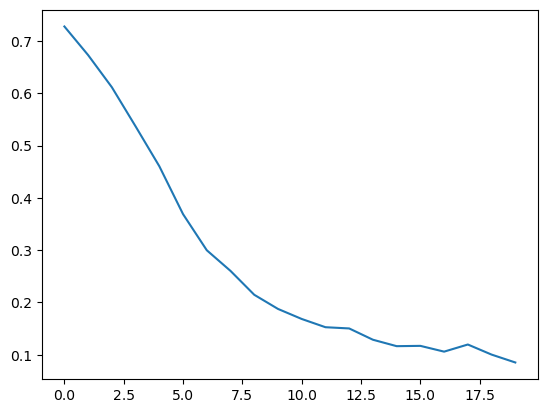

0:00:12.816600
epoch 20:, dice_loss=0.07874404, lr= 0.001
0:00:13.825741
epoch 21:, dice_loss=0.07655209, lr= 0.001
0:00:13.779689
epoch 22:, dice_loss=0.07402471, lr= 0.001
0:00:13.812078
epoch 23:, dice_loss=0.07099746, lr= 0.001
0:00:14.056786
epoch 24:, dice_loss=0.06633561, lr= 0.001
0:00:14.316913
epoch 25:, dice_loss=0.06212738, lr= 0.001
0:00:13.093699
epoch 26:, dice_loss=0.06251369, lr= 0.001
0:00:13.154058
epoch 27:, dice_loss=0.06427296, lr= 0.001
0:00:13.177843
epoch 28:, dice_loss=0.06529351, lr= 0.001
0:00:13.605647
epoch 29:, dice_loss=0.05721708, lr= 0.001


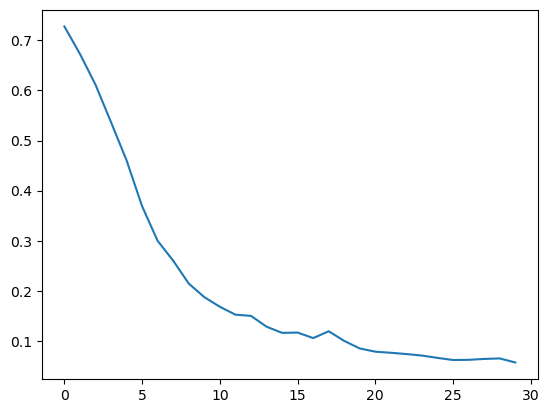

0:00:13.937237
epoch 30:, dice_loss=0.05956369, lr= 0.001
0:00:14.392811
epoch 31:, dice_loss=0.05698143, lr= 0.001
0:00:13.774912
epoch 32:, dice_loss=0.06517272, lr= 0.001
0:00:13.932148
epoch 33:, dice_loss=0.06458988, lr= 0.001
0:00:13.723669
epoch 34:, dice_loss=0.05700599, lr= 0.001
0:00:13.524769
epoch 35:, dice_loss=0.05866281, lr= 0.001
0:00:13.961652
epoch 36:, dice_loss=0.06266244, lr= 0.001
0:00:13.999272
epoch 37:, dice_loss=0.05354424, lr= 0.001
0:00:14.136787
epoch 38:, dice_loss=0.05275985, lr= 0.001
0:00:14.276458
epoch 39:, dice_loss=0.05158971, lr= 0.0005


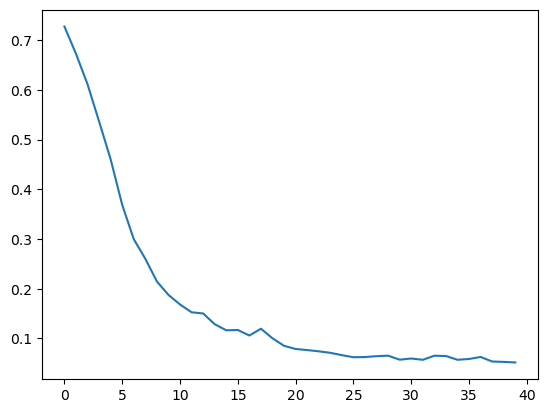

0:00:14.255815
epoch 40:, dice_loss=0.04819220, lr= 0.0005
0:00:13.961827
epoch 41:, dice_loss=0.04636394, lr= 0.0005
0:00:13.911054
epoch 42:, dice_loss=0.04495894, lr= 0.0005
0:00:14.136513
epoch 43:, dice_loss=0.04535970, lr= 0.0005
0:00:13.648777
epoch 44:, dice_loss=0.04452500, lr= 0.0005
0:00:13.939574
epoch 45:, dice_loss=0.04355667, lr= 0.0005
0:00:14.656279
epoch 46:, dice_loss=0.04260743, lr= 0.0005
0:00:13.595875
epoch 47:, dice_loss=0.04246766, lr= 0.0005
0:00:14.783700
epoch 48:, dice_loss=0.04139442, lr= 0.0005
0:00:14.673242
epoch 49:, dice_loss=0.04083899, lr= 0.0005


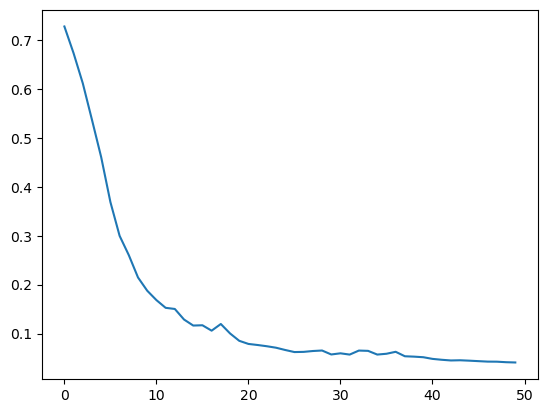

0:00:13.709783
epoch 50:, dice_loss=0.04058246, lr= 0.0005
0:00:14.259925
epoch 51:, dice_loss=0.04032211, lr= 0.0005
0:00:13.734373
epoch 52:, dice_loss=0.04361923, lr= 0.0005
0:00:14.103411
epoch 53:, dice_loss=0.04149620, lr= 0.0005
0:00:14.103386
epoch 54:, dice_loss=0.04046694, lr= 0.0005
0:00:14.298881
epoch 55:, dice_loss=0.03867608, lr= 0.0005
0:00:13.709884
epoch 56:, dice_loss=0.03996927, lr= 0.0005
0:00:14.218079
epoch 57:, dice_loss=0.04029559, lr= 0.0005
0:00:13.945994
epoch 58:, dice_loss=0.03939788, lr= 0.0005
0:00:13.693978
epoch 59:, dice_loss=0.03942014, lr= 0.0005


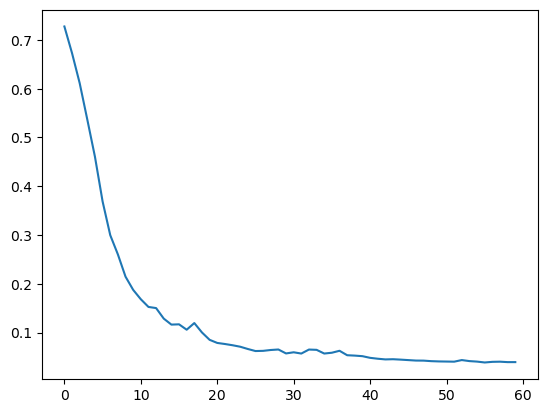

0:00:14.065941
epoch 60:, dice_loss=0.03940376, lr= 0.0005
0:00:13.916759
epoch 61:, dice_loss=0.03873819, lr= 0.0005
0:00:13.776600
epoch 62:, dice_loss=0.03694692, lr= 0.0005
0:00:13.611040
epoch 63:, dice_loss=0.03677034, lr= 0.0005
0:00:13.920157
epoch 64:, dice_loss=0.03576559, lr= 0.0005
0:00:14.072973
epoch 65:, dice_loss=0.03576409, lr= 0.0005
0:00:14.019244
epoch 66:, dice_loss=0.03646664, lr= 0.0005
0:00:13.592731
epoch 67:, dice_loss=0.03819653, lr= 0.0005
0:00:14.278312
epoch 68:, dice_loss=0.03592550, lr= 0.0005
0:00:15.003296
epoch 69:, dice_loss=0.03513614, lr= 0.0005


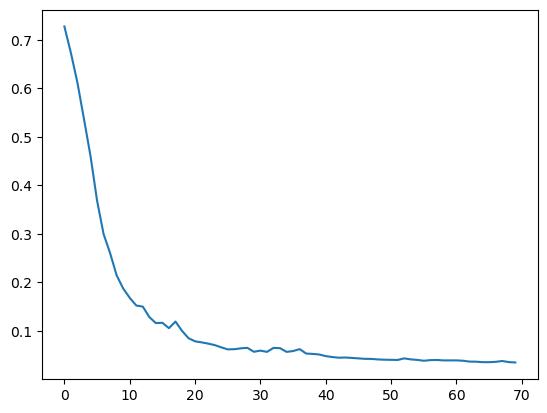

0:00:13.611244
epoch 70:, dice_loss=0.03719510, lr= 0.0005
0:00:14.048995
epoch 71:, dice_loss=0.03885731, lr= 0.0005
0:00:13.693380
epoch 72:, dice_loss=0.03926899, lr= 0.0005
0:00:14.467082
epoch 73:, dice_loss=0.03940539, lr= 0.0005
0:00:14.647434
epoch 74:, dice_loss=0.03610184, lr= 0.0005
0:00:13.592776
epoch 75:, dice_loss=0.03445951, lr= 0.0005
0:00:13.618773
epoch 76:, dice_loss=0.03285950, lr= 0.0005
0:00:13.560145
epoch 77:, dice_loss=0.03379953, lr= 0.0005
0:00:13.833155
epoch 78:, dice_loss=0.03368588, lr= 0.0005
0:00:13.522323
epoch 79:, dice_loss=0.03256402, lr= 0.00025


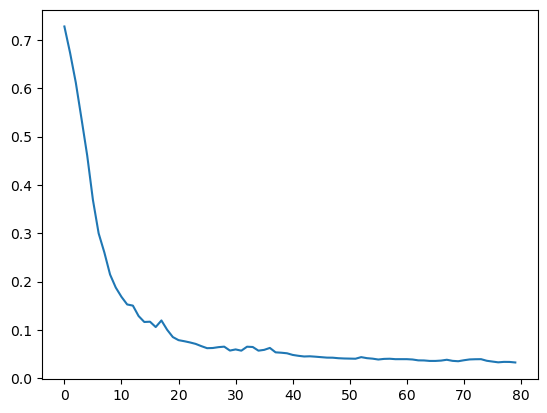

0:00:13.787274
epoch 80:, dice_loss=0.03270081, lr= 0.00025
0:00:13.679528
epoch 81:, dice_loss=0.03389484, lr= 0.00025
0:00:13.991649
epoch 82:, dice_loss=0.03251580, lr= 0.00025
0:00:13.563838
epoch 83:, dice_loss=0.03200570, lr= 0.00025
0:00:13.326395
epoch 84:, dice_loss=0.03165165, lr= 0.00025
0:00:13.718502
epoch 85:, dice_loss=0.03126659, lr= 0.00025
0:00:13.862765
epoch 86:, dice_loss=0.03056237, lr= 0.00025
0:00:13.994047
epoch 87:, dice_loss=0.03092240, lr= 0.00025
0:00:13.405561
epoch 88:, dice_loss=0.03224526, lr= 0.00025
0:00:14.582246
epoch 89:, dice_loss=0.03079730, lr= 0.00025


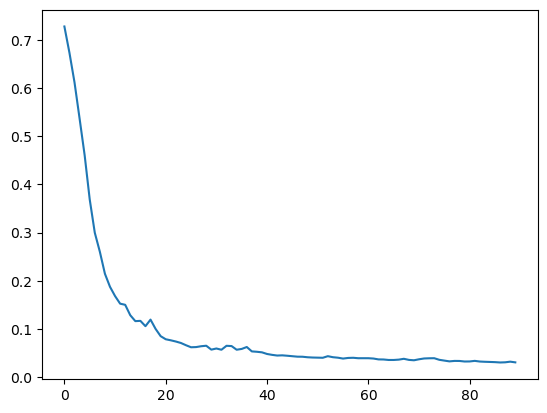

0:00:14.129831
epoch 90:, dice_loss=0.03032627, lr= 0.00025
0:00:14.341264
epoch 91:, dice_loss=0.02932465, lr= 0.00025
0:00:14.043375
epoch 92:, dice_loss=0.02907404, lr= 0.00025
0:00:14.038676
epoch 93:, dice_loss=0.02922761, lr= 0.00025
0:00:13.976477
epoch 94:, dice_loss=0.02887392, lr= 0.00025
0:00:13.707222
epoch 95:, dice_loss=0.02845033, lr= 0.00025
0:00:13.638133
epoch 96:, dice_loss=0.02900093, lr= 0.00025
0:00:12.870524
epoch 97:, dice_loss=0.03190774, lr= 0.00025
0:00:12.450249
epoch 98:, dice_loss=0.03067906, lr= 0.00025
0:00:13.024214
epoch 99:, dice_loss=0.03096566, lr= 0.00025


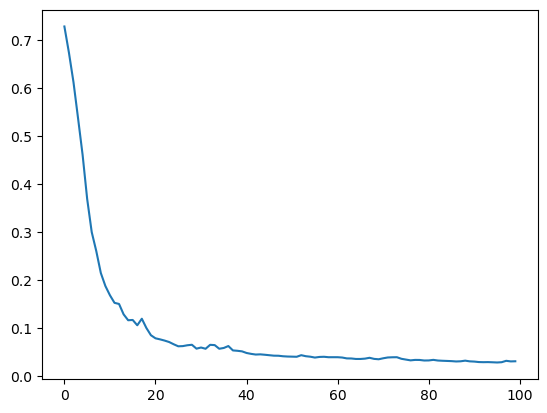

0:00:13.047641
epoch 100:, dice_loss=0.02887217, lr= 0.00025
0:00:12.823510
epoch 101:, dice_loss=0.02848780, lr= 0.00025
0:00:13.140022
epoch 102:, dice_loss=0.02837320, lr= 0.00025
0:00:12.784323
epoch 103:, dice_loss=0.02917142, lr= 0.00025
0:00:12.565334
epoch 104:, dice_loss=0.02928729, lr= 0.00025
0:00:12.718077
epoch 105:, dice_loss=0.02814310, lr= 0.00025


KeyboardInterrupt: 

In [30]:
m.fit()

Validation

In [31]:
def calculate_dice(pred, mask):
    intersection = np.multiply(pred,mask)
    union  = np.sum(pred) + np.sum(mask)
    dice = (2 * np.sum(intersection))/union
    return dice
best_i = -1
best_dice = 0
for i in range(80,100):
    m.load_model(i)
    pred, masks = m.validate('val', 32)
    # pred = pred.astype(np.uint16)
    dice = 0
    t = 0
    for j  in range(len(pred)):
        if np.count_nonzero(masks[j]) != 0:
            dice += calculate_dice(masks[j], pred[j])
            t += 1
    dice /= t
    print('epoch = ', i,'dice = ', dice)
    if dice > best_dice:
        best_i = i
        best_dice = dice
print('best_i = ', best_i)

epoch =  80 dice =  0.9590825182163364
epoch =  81 dice =  0.9555048755799899
epoch =  82 dice =  0.9537196123750142
epoch =  83 dice =  0.9581414289555286
epoch =  84 dice =  0.9605176265674257
epoch =  85 dice =  0.9609009970527407
epoch =  86 dice =  0.9592996949685478
epoch =  87 dice =  0.9583624480120444
epoch =  88 dice =  0.9612719757054249
epoch =  89 dice =  0.9468595092815252
epoch =  90 dice =  0.962664017860427
epoch =  91 dice =  0.9612390043545669
epoch =  92 dice =  0.9598587860678229
epoch =  93 dice =  0.9600962987507714
epoch =  94 dice =  0.9578874910804721
epoch =  95 dice =  0.9585540339883257
epoch =  96 dice =  0.9563287875515845
epoch =  97 dice =  0.9600560938866173
epoch =  98 dice =  0.9609430769597793
epoch =  99 dice =  0.9616341301178598
best_i =  90


epoch =  69 dice =  0.962664017860427


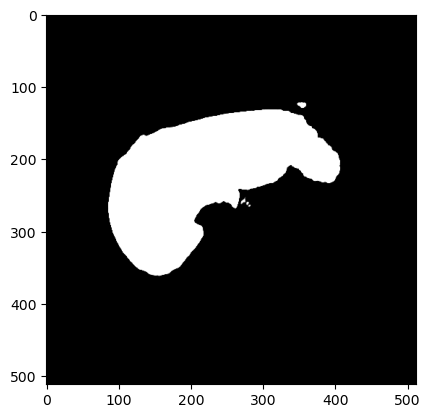

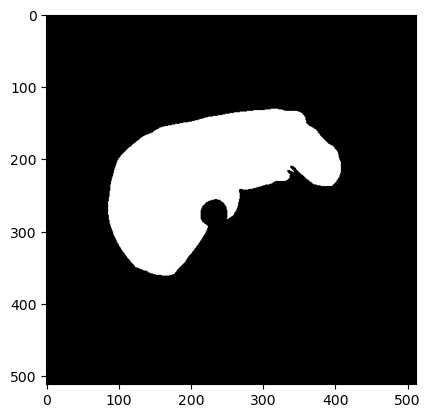

In [32]:
def calculate_dice(pred, mask):
    intersection = np.multiply(pred,mask)
    union  = np.sum(pred) + np.sum(mask)
    dice = (2 * np.sum(intersection))/union
    return dice
m.load_model(90)
pred, masks = m.validate('val', 32)
dice = 0
t = 0
for j  in range(len(pred)):
    if np.count_nonzero(masks[j]) != 0:
        dice += calculate_dice(masks[j], pred[j])
        t += 1
dice /= t
print('epoch = ', 69,'dice = ', dice)
plt.imshow(pred[25], cmap = 'gray')
plt.show()
plt.imshow(masks[25], cmap = 'gray')

In [ ]:
i = 0
plt.imshow(pred[i], cmap = 'gray')
plt.show()
plt.imshow(masks[i], cmap = 'gray')
dice = calculate_dice(masks[i], pred[i])
print(dice)

##Test

In [13]:
m.load_model(90)
save_path = '/bulk/liangy15/CHAOS/CHAOS_submission_template_new/Task2/CT'
pred, folders = m.validate('test', 32)
for j in range(len(pred)):
    if folders[j] != folders[j-1]: 
        k = 0
    save_folder = os.path.join(save_path,str(folders[j]),'Results')
    save_name = os.path.join(save_folder,'img{:0>3}.png'.format(k))
    plt.imsave(save_name, pred[j], cmap = 'gray')
    k += 1
